## Simulate Data

In [1]:
# Code to enable this notebook to import from libraries
import os
import sys
module_path = os.path.abspath(os.path.join('..\..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sns
import csv
from scripts.mockUtilities import *
from scripts.utilities import *

In [3]:
# Seed random state (for reproducibility)
np.random.seed(100)

In [4]:
## Parameters
N_GENES = 500
N_X_INDICES = 32
N_Y_INDICES = 32
# Code assumes each shape corresponds to a single factor
SHAPE_PARAMS = [
    ("rect", ((0-0.5,4-0.5),4,24,0)),
    ("regPoly", ((12,24),6,3,0)),
    ("circ", ((12,8),6)),
    ("regPoly", ((26,24),6,5,0)),
    ("regPoly", ((26,8),6,6,0)),
]
SHAPES = shapes_from_param_list(SHAPE_PARAMS)
FACTOR_ACTIVE_GENES = (
    tuple(range(0,100)),
    tuple(range(100,200)),
    tuple(range(200,300)),
    tuple(range(300,400)),
    tuple(range(400,500)),
)
N_SHAPES = len(SHAPES)
N_FACTORS = len(FACTOR_ACTIVE_GENES)
assert N_SHAPES == N_FACTORS # A check since we're assuming each shape corresponds to a single factor

SNR = 0.1

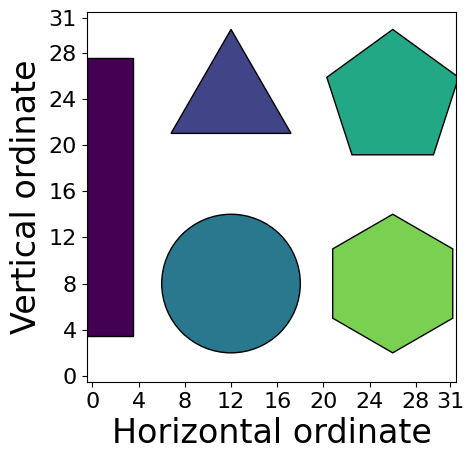

In [5]:
# Visualise the shapes
plot_rectangles(SHAPES, 0, N_X_INDICES, 0, N_Y_INDICES,
                x_label="Horizontal ordinate", y_label="Vertical ordinate",
                x_ticks=np.append(np.arange(0,32,4), 31),
                y_ticks=np.append(np.arange(0,32,4), 31))

In [6]:
## Generate gene panel
gene_panel_df = get_gene_panel_df(N_GENES)

In [7]:
## Generate data
factor_gene_matrix = create_factor_gene_matrix(FACTOR_ACTIVE_GENES, N_FACTORS, N_GENES)
factor_spot_matrix = create_factor_spot_matrix(SHAPES, N_FACTORS, N_X_INDICES, N_Y_INDICES)
data_matrix_noiseless = np.dot(factor_gene_matrix, factor_spot_matrix)

tau = get_tau_spot(SNR, data_matrix_noiseless.transpose())
assert(tau.shape == data_matrix_noiseless.transpose().shape)
error_matrix = get_error_from_tau_spot(tau).transpose()
data_matrix = data_matrix_noiseless + error_matrix

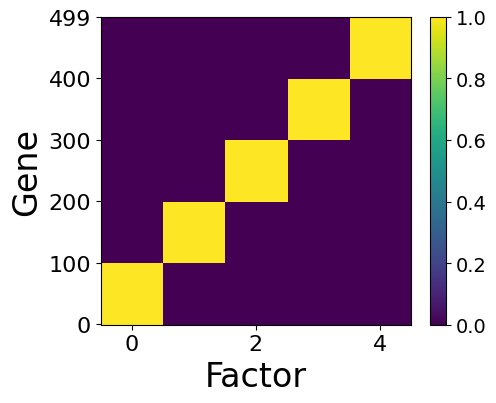

In [8]:
plot_matrix(factor_gene_matrix, x_label='Factor', y_label='Gene',
            y_ticks=np.append(np.arange(0,500,100), 499))

In [9]:
df = spot_feature_matrix_to_dataframe(data_matrix, N_X_INDICES, N_Y_INDICES)

## Processing Data

In [10]:
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pywt
import pywt.data
from sklearn.cluster import SpectralClustering
from matplotlib.colors import ListedColormap
from scipy.sparse import csr_matrix
from scipy.io import mmread
from sklearn.mixture import GaussianMixture
%matplotlib inline

In [11]:
y_index_number = N_Y_INDICES
x_index_number = N_X_INDICES
rna_binned = df.rename(columns=lambda x: x.replace('feature_', 'gene_indicator_'))
gene_panels = gene_panel_df.rename(columns={'x': 'gene'})

# Column renaming
current_columns = rna_binned.columns
new_columns = ['gene_indicator_{}'.format(i.split('_')[-1]) for i in current_columns]
rna_binned.rename(columns=dict(zip(current_columns, new_columns)), inplace=True)

In [12]:
result_rna_unnormalised = rna_binned.copy()
result_rna_unnormalised['feature'] = result_rna_unnormalised.apply(lambda row: row.tolist(), axis=1)
result_rna_unnormalised = result_rna_unnormalised.drop(result_rna_unnormalised.columns[:-1], axis=1)
result_rna_unnormalised = result_rna_unnormalised.reset_index()

In [13]:
# Perform standardization 
from sklearn.preprocessing import StandardScaler
result_rna = result_rna_unnormalised.copy()
matrix = result_rna_unnormalised['feature'].tolist()
matrix = np.array(matrix)
scaler = StandardScaler()
matrix_standardized = scaler.fit_transform(matrix)
standardized_features = matrix_standardized.tolist()
result_rna['feature'] = standardized_features

In [14]:
assert np.allclose(matrix_standardized.mean(axis=0),np.array([0.0]*N_GENES))
assert np.allclose(matrix_standardized.std(axis=0),np.array([1.0]*N_GENES))

## Run PCA

In [15]:
n_components = N_FACTORS
feats = np.vstack(result_rna['feature'].to_numpy())
pca = PCA(n_components=n_components)
flattened_L_pca = pca.fit_transform(feats)
F_pca = pca.components_ # F matrix, factor vs feature

L_pca = [np.zeros((N_Y_INDICES, N_X_INDICES)) for _ in range(n_components)]
for i, row in result_rna.iterrows():
    y_idx = row['y_index']
    x_idx = row['x_index']
    
    for component_index in range(n_components):
        L_pca[component_index][y_idx, x_idx] = flattened_L_pca[i, component_index]\

LF_pca = pca.inverse_transform(flattened_L_pca).transpose()

## Run WaviFM

In [16]:
from IPython.display import display, HTML
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from sklearn.mixture import GaussianMixture
from scripts.cavi_plot_utilities import *
from scripts.cavi import *
import copy
from scripts.cavi_utilities import *
from scripts.cavi_evaluation import *
from scripts.utilities import *
from scripts.run_wavifm import *

%matplotlib inline

In [17]:
N_LENGTH_SCALES = 3 # D in thesis
n_spots = N_X_INDICES*N_Y_INDICES

In [18]:
results = run_wavifm(
    result_rna=result_rna,
    n_length_scales=N_LENGTH_SCALES,
    n_factors=N_FACTORS,
    n_x_indices=N_X_INDICES,
    n_y_indices=N_Y_INDICES,
    max_iterations=1000,
    relative_elbo_threshold=0.0001,
    n_init=10
)
param_results = results["parameters"]

Initialisation 1:
	ELBO = -710457.6760369207
	#Iterations = 13
	Time taken (s) = 5.985070466995239
Initialisation 2:
	ELBO = -710940.7382556036
	#Iterations = 17
	Time taken (s) = 7.886110782623291
Initialisation 3:
	ELBO = -710179.0557883391
	#Iterations = 27
	Time taken (s) = 12.47042727470398
Initialisation 4:
	ELBO = -707518.7128438768
	#Iterations = 17
	Time taken (s) = 7.889541864395142
Initialisation 5:
	ELBO = -707688.6550050774
	#Iterations = 20
	Time taken (s) = 9.307960271835327
Initialisation 6:
	ELBO = -718658.5554332825
	#Iterations = 139
	Time taken (s) = 60.09019899368286
Initialisation 7:
	ELBO = -710435.6087562578
	#Iterations = 70
	Time taken (s) = 31.091978788375854
Initialisation 8:
	ELBO = -707310.5454553191
	#Iterations = 72
	Time taken (s) = 32.51673150062561
Initialisation 9:
	ELBO = -707729.5383276918
	#Iterations = 15
	Time taken (s) = 7.127969980239868
Initialisation 10:
	ELBO = -710490.6322911726
	#Iterations = 18
	Time taken (s) = 8.316119194030762
Initial

## Processing results

In [19]:
L_means = variational_approx_posterior_mean_L(param_results)
F_means = variational_approx_posterior_mean_F(param_results)
pi_means = variational_approx_posterior_mean_pi(param_results)
eta_means = variational_approx_posterior_mean_eta(param_results)

In [20]:
# Factor matching (so that inferred factors can be visually viewed in a manner that lines up with the ground truths)
# Factor orders specified below were manually determined by looking at plots of inferred hyperparameters and comparing to the ground truth
factor_order_from_1 = (4,1,2,5,3)
factor_order = [i-1 for i in factor_order_from_1]

# Shifting order for L, pi
L_means = [L_means[i] for i in factor_order]
pi_means = [pi_means[i] for i in factor_order]

# Shifting order for F, eta
F_means = F_means[factor_order]
eta_means = eta_means[factor_order]

Get factor activities in spatial domain

In [21]:
def square_flattened_matrix(flattened_matrix):
    flattened_matrix_arr = np.array(flattened_matrix)
    n = int(np.sqrt(len(flattened_matrix_arr)))
    square_matrix = flattened_matrix_arr.reshape((n, n))
    return square_matrix

In [22]:
L_means_formatted = copy.deepcopy(L_means)
n_factors, n_features = np.array(param_results["mu_F"]).shape
mean_values = copy.deepcopy(param_results["mu_L"])

for l in range(n_factors):
    for i in range(len(param_results["mu_L"][l])):
        for j in range(len(param_results["mu_L"][l][i])):
            L_means_formatted[l][i][j] = square_flattened_matrix(L_means[l][i][j])

for l in range(n_factors):
    L_means_formatted[l][0] = square_flattened_matrix(L_means[l][0][0])

In [23]:
# Inverse Wavelet Transform on the factor loadings
idwt_L_means = [None]*n_factors

for l in range(n_factors):
    print(f"factor {l}")
    idwt_L_means[l] = pywt.waverec2(L_means_formatted[l], 'haar')

factor 0
factor 1
factor 2
factor 3
factor 4


## Analysis

In [24]:
flattened_true_LF = data_matrix_noiseless
true_LF_df = spot_feature_matrix_to_dataframe(flattened_true_LF, N_X_INDICES, N_Y_INDICES)
flattened_true_Y = data_matrix
true_Y_df = spot_feature_matrix_to_dataframe(flattened_true_Y, N_X_INDICES, N_Y_INDICES)

In [25]:
true_F = factor_gene_matrix.transpose()
true_L = [np.zeros((N_Y_INDICES, N_X_INDICES)) for _ in range(n_components)]
for i, row in result_rna.iterrows():
    y_idx = row['y_index']
    x_idx = row['x_index']
    for component_index in range(n_components):
        true_L[component_index][y_idx, x_idx] = factor_spot_matrix.transpose()[i, component_index]

In [26]:
flattened_idwt_L_means = np.zeros((n_components, n_spots))
for i, row in result_rna.iterrows(): # Basically the inverse of the procedure previously to get true_L from factor_spot_matrix
    y_idx = row['y_index']
    x_idx = row['x_index']
    for component_index in range(n_components):
        flattened_idwt_L_means[component_index,i] = idwt_L_means[component_index][y_idx, x_idx]
flattened_F_means = F_means.transpose()
flattened_LF_means = np.dot(flattened_F_means, flattened_idwt_L_means)

In [27]:
assert factor_spot_matrix.shape == flattened_idwt_L_means.shape
assert factor_gene_matrix.shape == flattened_F_means.shape
assert flattened_true_LF.shape == flattened_LF_means.shape
assert LF_pca.shape == flattened_LF_means.shape

In [28]:
# RRMSE
rrmse_wavifm = {
    "Inferred LF to True LF": rrmse(flattened_true_LF, flattened_LF_means)
}
rrmse_pca = {
    "Inferred LF to True LF": rrmse(flattened_true_LF, LF_pca)
}
rrmse_df = pd.DataFrame([rrmse_wavifm, rrmse_pca], index=["WaviFM", "PCA"])
rrmse_df

,Inferred LF to True LF
WaviFM,0.386547
PCA,0.479160


In [29]:
rb_centred_color_map = create_custom_colormap()

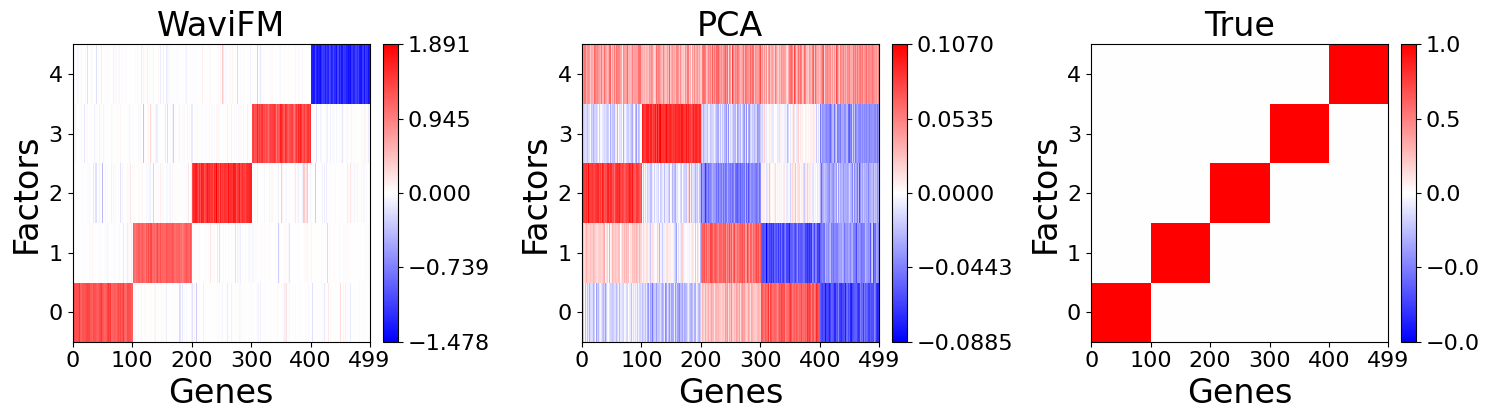

In [30]:
# Comparing F on different color scale
plot_matrices_side_by_side(F_means, F_pca, true_F,
                           titles=["WaviFM", "PCA", "True"],
                           colormaps=[rb_centred_color_map, rb_centred_color_map, rb_centred_color_map],
                           x_labels=["Genes","Genes","Genes"],
                           y_labels=["Factors","Factors","Factors"],
                           aspect="auto",
                           x_ticks=np.append(np.arange(0,500,100), 499),
                           figsize=(15,4.3),
                           exact_color_ticks=True,
                           )

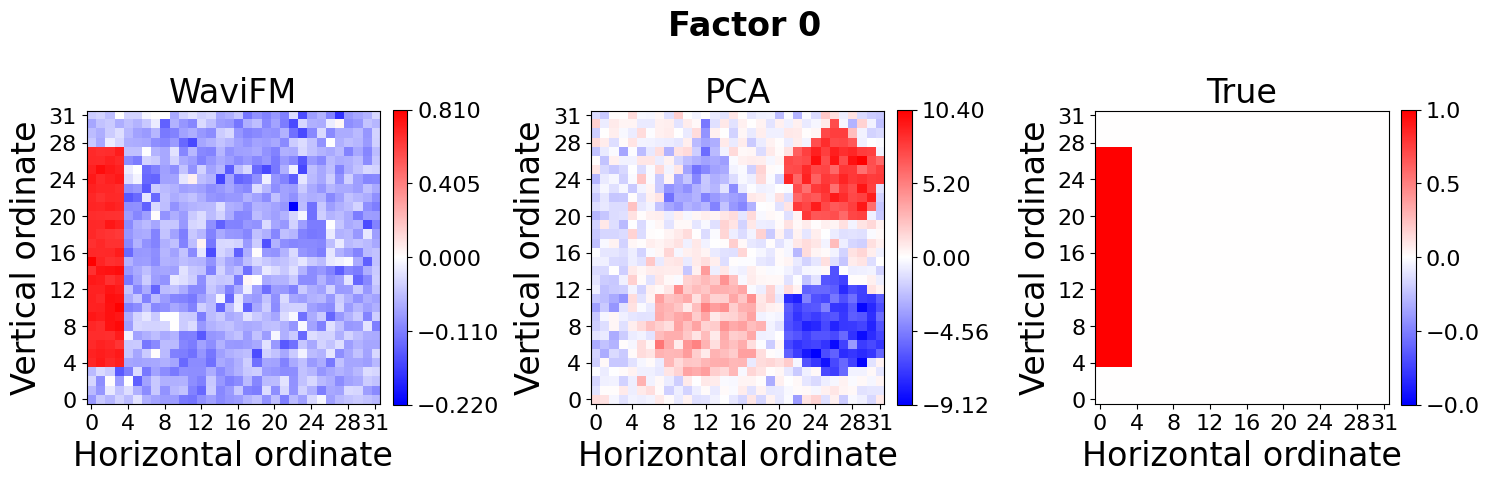

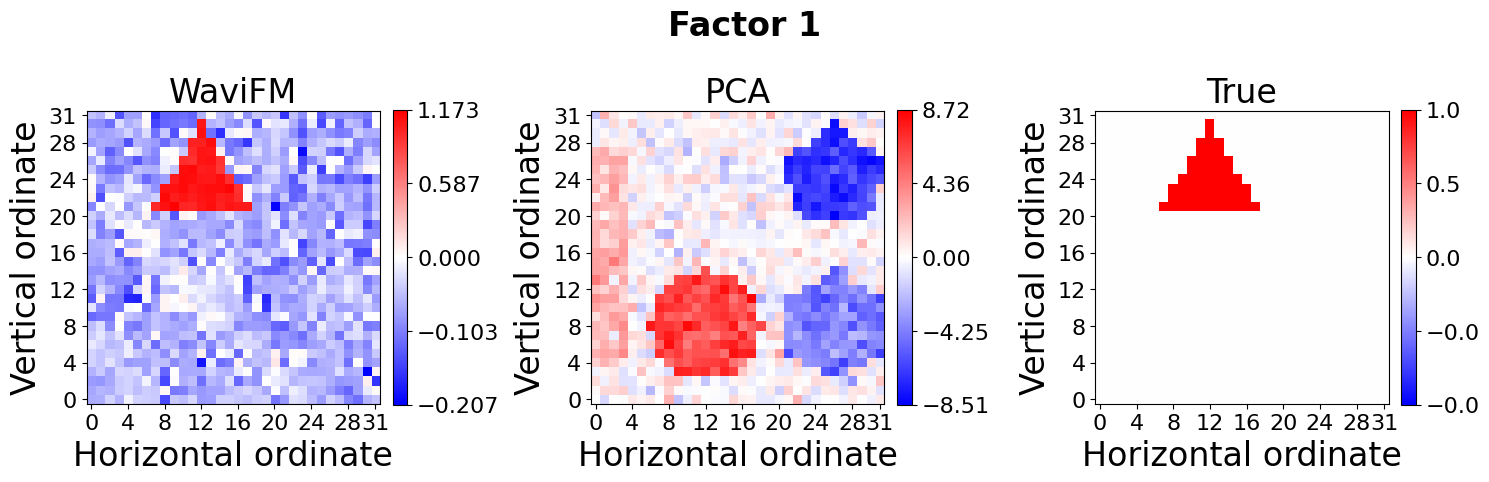

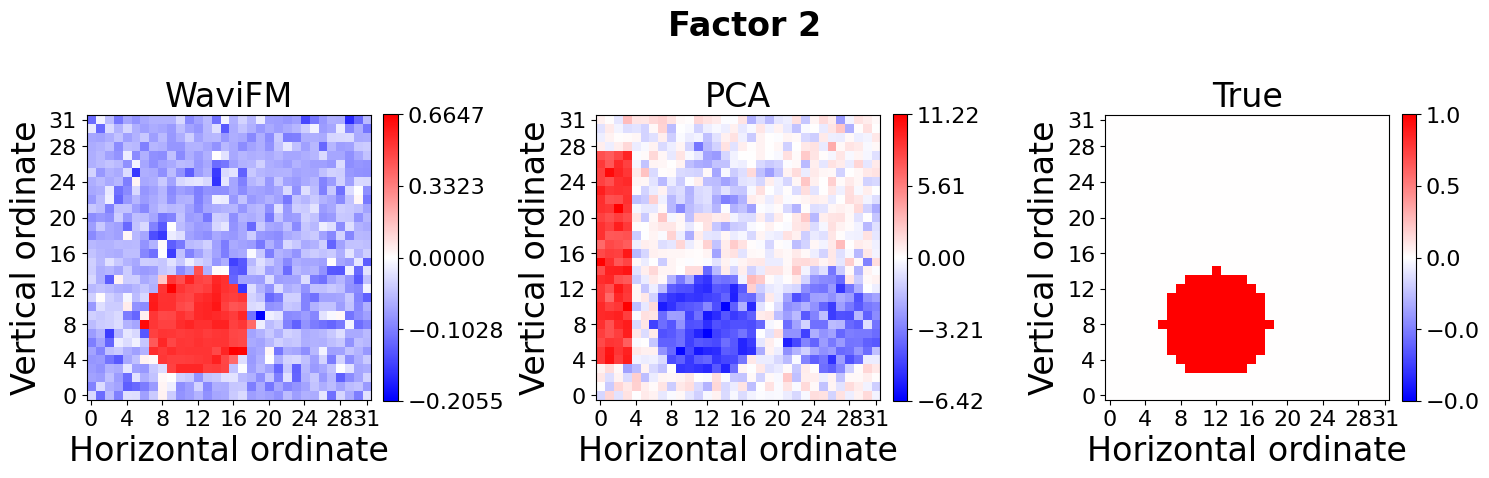

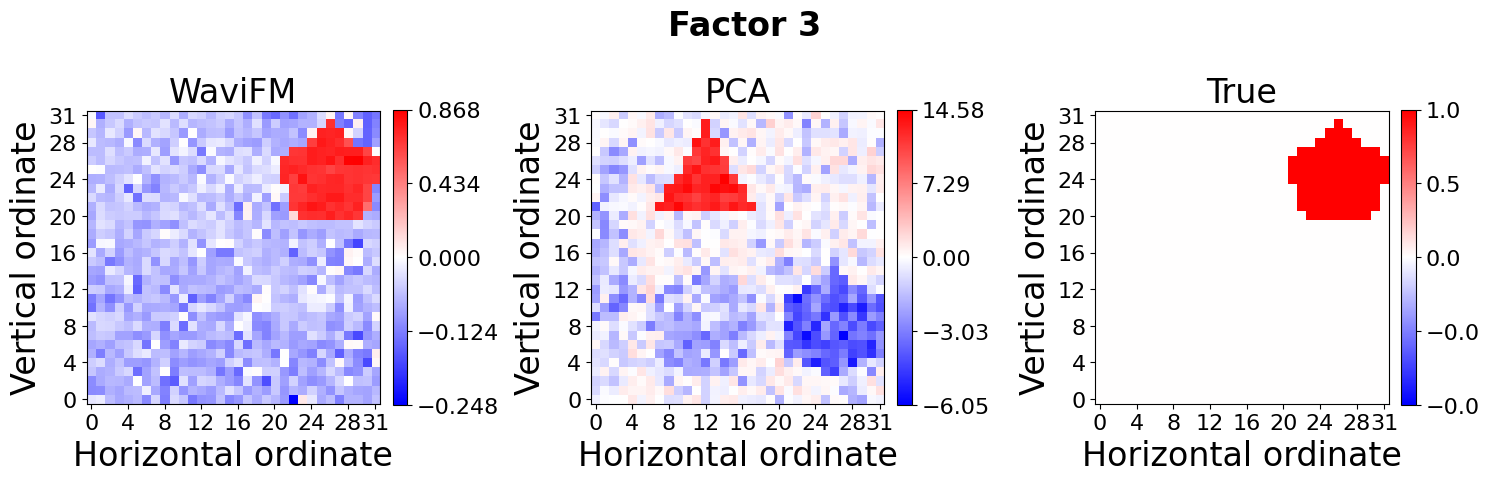

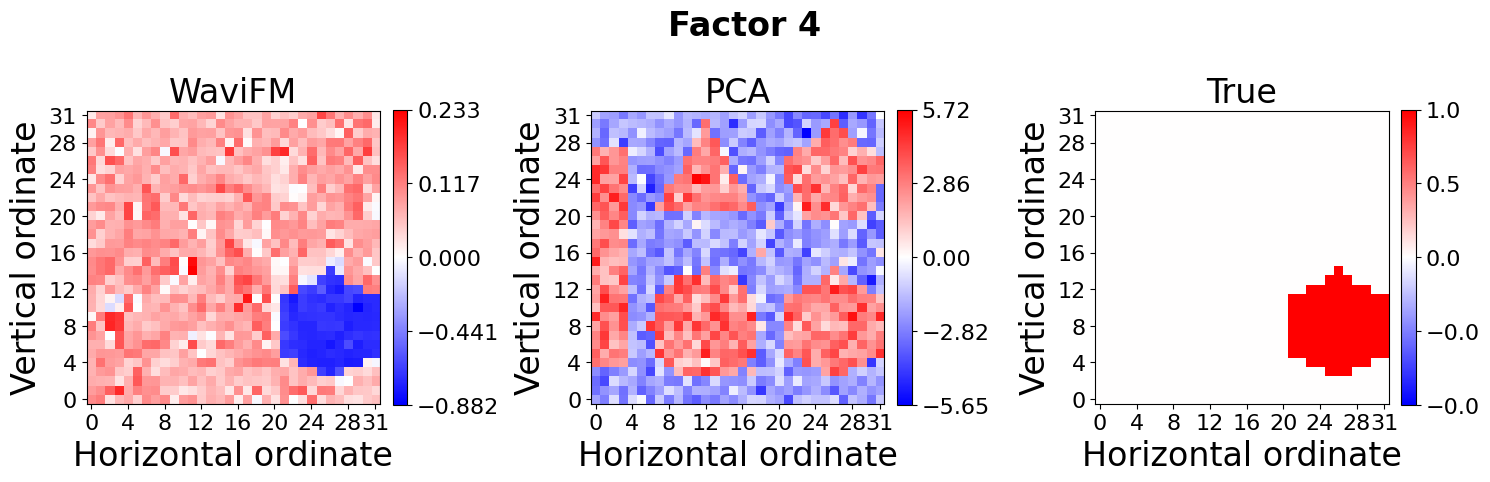

In [31]:
# Compare L for the individual factors in spot space
for i in range(n_factors):
    plot_matrices_side_by_side(
        idwt_L_means[i], L_pca[i], true_L[i],
        overall_title=f"Factor {i}",
        titles=["WaviFM", "PCA", "True"],
        colormaps=[rb_centred_color_map, rb_centred_color_map, rb_centred_color_map],
        x_labels=["Horizontal ordinate","Horizontal ordinate","Horizontal ordinate"],
        y_labels=["Vertical ordinate","Vertical ordinate","Vertical ordinate"],
        same_scale=False,
        x_ticks=np.append(np.arange(0,32,4), 31),
        y_ticks=np.append(np.arange(0,32,4), 31),
        exact_color_ticks=True,
    )